In [ ]:
!unzip "drive/MyDrive/Grape.zip"

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
Channels = 3
EPOCHS = 25
INPUT_SHAPE = (IMG_SIZE , IMG_SIZE , Channels)

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Grape",
    shuffle = True,
    image_size = (IMG_SIZE , IMG_SIZE),
    batch_size = BATCH_SIZE
)

Found 3881 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy']

In [7]:
def get_dataset_partitions_tf(ds , train_split = 0.8,val_split=0.1,test_split=0.1,shuffle=True ,shuffle_size=1000):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds , val_ds , test_ds

In [8]:
train_ds , val_ds , test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
data_agumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
vgg = tf.keras.applications.VGG16(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

In [13]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [14]:
n_classes = 3
model = tf.keras.Sequential()
model.add(resize_and_rescale)
model.add(data_agumentation)
model.add(vgg)
model.add(Flatten())
model.add(Dense(n_classes,activation='softmax'))
model.build(input_shape=(None, IMG_SIZE, IMG_SIZE, Channels))

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 3)                 75267     
                                                                 
Total params: 14789955 (56.42 MB)
Trainable params: 75267 (294.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    epochs = 25,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/25
97/97 [==============================] - 36s 212ms/step - loss: 0.2013 - accuracy: 0.9348 - val_loss: 0.0232 - val_accuracy: 0.9974
Epoch 2/25
97/97 [==============================] - 17s 173ms/step - loss: 0.0165 - accuracy: 0.9977 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 3/25
97/97 [==============================] - 16s 164ms/step - loss: 0.0106 - accuracy: 0.9990 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 4/25
97/97 [==============================] - 16s 161ms/step - loss: 0.0068 - accuracy: 0.9994 - val_loss: 0.0051 - val_accuracy: 1.0000
Epoch 5/25
97/97 [==============================] - 15s 158ms/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 6/25
97/97 [==============================] - 15s 159ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 7/25
97/97 [==============================] - 16s 165ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0031 - val_accuracy: 1.0000

In [18]:
model.save("grape_vgg16.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
training_acc = history.history['accuracy']
training_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

In [20]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 8s 137ms/step - loss: 5.0699e-04 - accuracy: 1.0000


In [21]:

import matplotlib.pyplot as plt

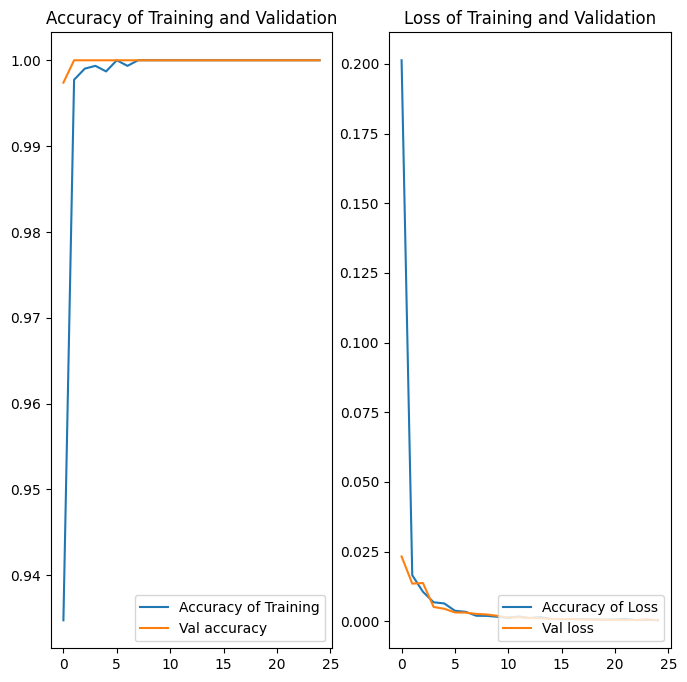

In [22]:
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(range(len(training_acc)), training_acc, label='Accuracy of Training')
plt.plot(range(len(val_acc)), val_acc, label='Val accuracy')
plt.legend(loc='lower right')
plt.title("Accuracy of Training and Validation")

plt.subplot(1, 2, 2)
plt.plot(range(len(training_loss)), training_loss, label='Accuracy of Loss')
plt.plot(range(len(val_loss)), val_loss, label='Val loss')
plt.legend(loc='lower right')
plt.title("Loss of Training and Validation")

plt.show()

In [23]:
import numpy as np

first image to predict
first image's actual label: Grape___healthy
1/1 [==============================] - 0s 300ms/step
predicted label: Grape___healthy


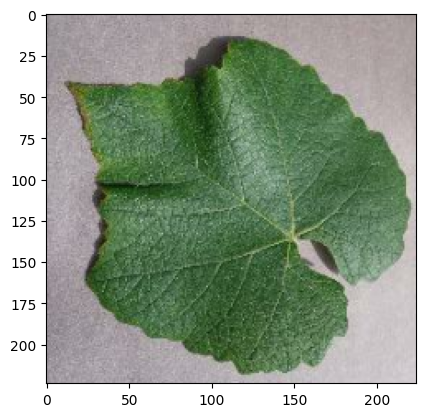

In [24]:
for images_batch , labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)

    print("first image's actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model , img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class , confidence

1/1 [==============================] - 0s 17ms/step


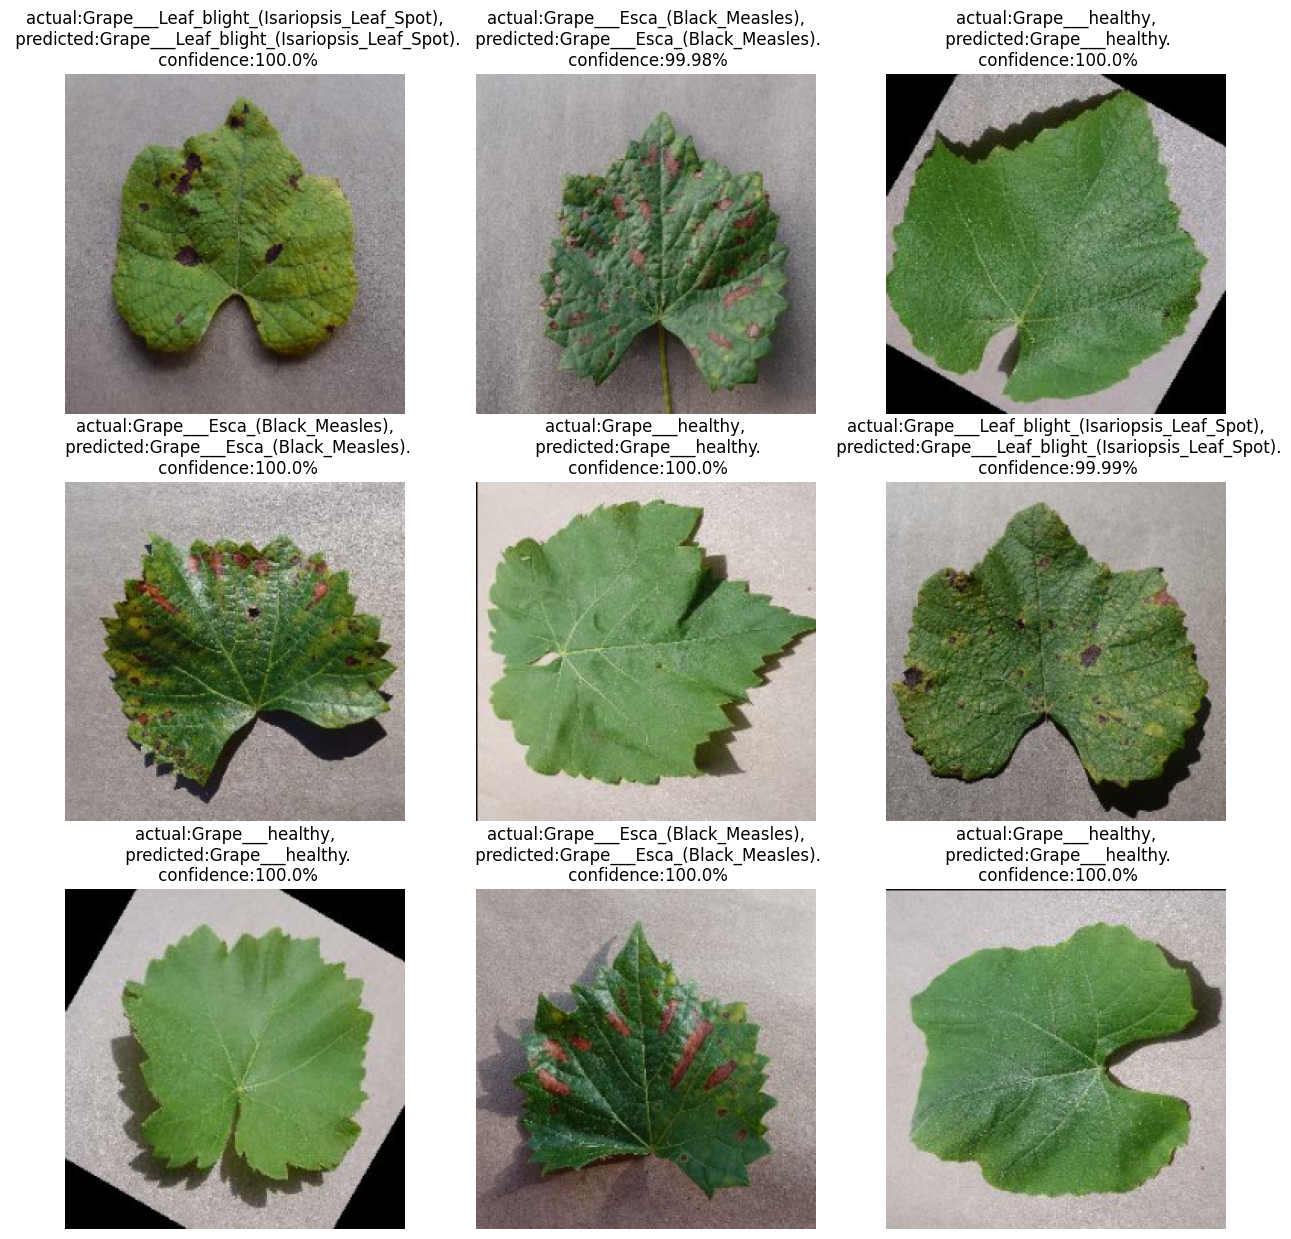

In [26]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model , images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"actual:{actual_class},\n predicted:{predicted_class}.\n confidence:{confidence}%")
        plt.axis('off')